# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [ ]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNeXt101_64X4D_Weights.IMAGENET1K_V1
model = models.resnext101_64x4d(weights=weights)
transforms1 = weights.transforms()

AttributeError: IMAGENET1K_V2

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [ ]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [ ]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =int(piece['category_id'])
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

NameError: name 'data_aug' is not defined

In [ ]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [ ]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

['R', '-', 'B', 'K', '-', '-', 'N', 'R']
['P', '-', 'P', 'P', 'Q', '-', 'P', 'P']
['-', 'P', 'N', '-', '-', '-', '-', '-']
['-', '-', '-', '-', 'P', 'P', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', 'p', '-']
['p', 'p', 'p', '-', 'p', 'p', 'b', 'p']
['r', '-', '-', 'k', 'q', '-', 'n', 'r']


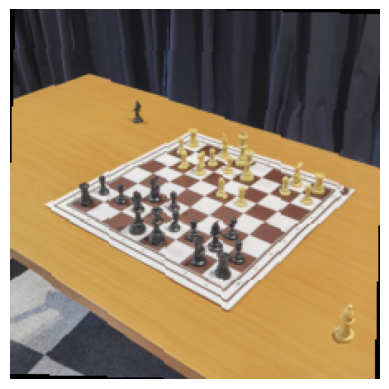

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


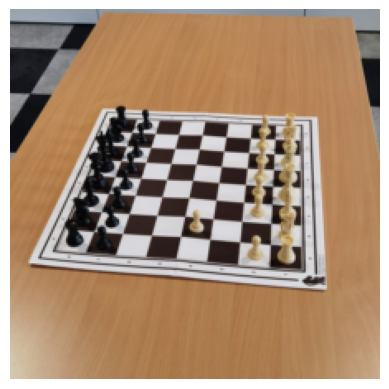

In [ ]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[0].shape)
    #print(labels[0])
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    #print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[1])
    print_readable_board(labels[1])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 832)
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, 64),
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    all_preds = (all_preds.detach().numpy()).round().astype(int)
    all_labels = all_labels.detach().numpy().astype(int)
    #print("Test1 :",all_labels.flatten().shape, all_preds.flatten().shape)
    #print("Test1 :",all_labels.flatten(), all_preds.flatten())
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    recall1 = recall_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    precision1 = precision_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    f11 = f1_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    print(f"Micro: Recall: {recall1:.4f}, Precision: {precision1:.4f}, F1: {f11:.4f}")
    return accuracy, recall, precision, f1
def claculateMissMatchs(all_preds, all_labels):
    accuracyList = np.zeros(64, dtype=int)
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      missmatched =total- correct
      accuracyList[missmatched] += 1
    return accuracyList

## Train the model

Define function to perform one iteration

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred).view(-1, 8, 8, 13)

          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          pred_loss = scaled_pred.permute(0, 3, 1, 2)
          #print("Pred shape:",pred_loss.shape,y.view( -1,8, 8).shape)
          loss = loss_fn( pred_loss, y.view( -1,8, 8))
          #print("Scaled pred shape:",scaled_pred)
          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
          #print("Test metrics:",scaled_pred.argmax(dim=-1).view( -1, 64).shape)
          preds.append(scaled_pred.argmax(dim=-1).view( -1, 64).cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    #print("All preds shape:",all_preds.shape)
    #print("All labels shape:",all_labels.shape)
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [ ]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  trigger_times = 0
  best_val_loss = float('inf')
  patience = 10  # Chess models often need longer to converge
  min_delta = 0.0001  # Minimum improvement to reset patience
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")


      # Early stoping
      if val_loss < (best_val_loss - min_delta):
          best_val_loss = val_loss
          trigger_times = 0
      else:
          trigger_times += 1
          if trigger_times >= patience:
              print("Early stopping!")
              break
      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [ ]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 20

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 809/809 [03:07<00:00,  4.32it/s]


Micro: Recall: 0.4645, Precision: 0.4645, F1: 0.4645
Train loss: 2.06402 	 Train acc: 0.00000 	 Train recall: 0.36500 	 Train precision: 0.23047 	 Train f1: 0.26676


100%|██████████| 274/274 [00:14<00:00, 18.93it/s]


Micro: Recall: 0.6680, Precision: 0.6680, F1: 0.6680
Val loss: 1.94508 	 Val acc: 0.00000 	 Val recall: 0.33869 	 Val precision: 0.36116 	 Val f1: 0.34506

Epoch 2


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.7386, Precision: 0.7386, F1: 0.7386
Train loss: 0.99061 	 Train acc: 0.00124 	 Train recall: 0.39189 	 Train precision: 0.64815 	 Train f1: 0.47690


100%|██████████| 274/274 [00:14<00:00, 18.95it/s]


Micro: Recall: 0.7773, Precision: 0.7773, F1: 0.7773
Val loss: 0.79502 	 Val acc: 0.00776 	 Val recall: 0.40877 	 Val precision: 0.76731 	 Val f1: 0.51666

Epoch 3


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.7762, Precision: 0.7762, F1: 0.7762
Train loss: 0.73983 	 Train acc: 0.00386 	 Train recall: 0.41400 	 Train precision: 0.76189 	 Train f1: 0.51836


100%|██████████| 274/274 [00:14<00:00, 18.70it/s]


Micro: Recall: 0.7970, Precision: 0.7970, F1: 0.7970
Val loss: 0.73467 	 Val acc: 0.01004 	 Val recall: 0.42101 	 Val precision: 0.82082 	 Val f1: 0.53817

Epoch 4


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.8095, Precision: 0.8095, F1: 0.8095
Train loss: 0.63241 	 Train acc: 0.00664 	 Train recall: 0.46238 	 Train precision: 0.80120 	 Train f1: 0.56838


100%|██████████| 274/274 [00:14<00:00, 18.97it/s]


Micro: Recall: 0.8180, Precision: 0.8180, F1: 0.8180
Val loss: 0.67088 	 Val acc: 0.01277 	 Val recall: 0.45396 	 Val precision: 0.84755 	 Val f1: 0.57152

Epoch 5


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.8384, Precision: 0.8384, F1: 0.8384
Train loss: 0.54690 	 Train acc: 0.00819 	 Train recall: 0.51040 	 Train precision: 0.83969 	 Train f1: 0.61810


100%|██████████| 274/274 [00:14<00:00, 18.93it/s]


Micro: Recall: 0.8405, Precision: 0.8405, F1: 0.8405
Val loss: 0.60558 	 Val acc: 0.01642 	 Val recall: 0.49606 	 Val precision: 0.86469 	 Val f1: 0.61353

Epoch 6


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.8636, Precision: 0.8636, F1: 0.8636
Train loss: 0.47311 	 Train acc: 0.01329 	 Train recall: 0.56295 	 Train precision: 0.86881 	 Train f1: 0.66887


100%|██████████| 274/274 [00:14<00:00, 18.96it/s]


Micro: Recall: 0.8575, Precision: 0.8575, F1: 0.8575
Val loss: 0.55532 	 Val acc: 0.01916 	 Val recall: 0.52709 	 Val precision: 0.86766 	 Val f1: 0.64013

Epoch 7


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.8813, Precision: 0.8813, F1: 0.8813
Train loss: 0.41700 	 Train acc: 0.01746 	 Train recall: 0.60167 	 Train precision: 0.88734 	 Train f1: 0.70430


100%|██████████| 274/274 [00:14<00:00, 18.91it/s]


Micro: Recall: 0.8732, Precision: 0.8732, F1: 0.8732
Val loss: 0.50486 	 Val acc: 0.03513 	 Val recall: 0.54602 	 Val precision: 0.89300 	 Val f1: 0.66044

Epoch 8


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.8952, Precision: 0.8952, F1: 0.8952
Train loss: 0.37362 	 Train acc: 0.02194 	 Train recall: 0.63604 	 Train precision: 0.89989 	 Train f1: 0.73423


100%|██████████| 274/274 [00:14<00:00, 18.82it/s]


Micro: Recall: 0.8808, Precision: 0.8808, F1: 0.8808
Val loss: 0.47016 	 Val acc: 0.03786 	 Val recall: 0.55854 	 Val precision: 0.89474 	 Val f1: 0.67252

Epoch 9


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.9062, Precision: 0.9062, F1: 0.9062
Train loss: 0.33933 	 Train acc: 0.02302 	 Train recall: 0.66605 	 Train precision: 0.90587 	 Train f1: 0.75844


100%|██████████| 274/274 [00:14<00:00, 18.91it/s]


Micro: Recall: 0.8931, Precision: 0.8931, F1: 0.8931
Val loss: 0.43267 	 Val acc: 0.04881 	 Val recall: 0.58062 	 Val precision: 0.88943 	 Val f1: 0.68800

Epoch 10


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9152, Precision: 0.9152, F1: 0.9152
Train loss: 0.31247 	 Train acc: 0.03044 	 Train recall: 0.69013 	 Train precision: 0.91344 	 Train f1: 0.77814


100%|██████████| 274/274 [00:14<00:00, 18.95it/s]


Micro: Recall: 0.9004, Precision: 0.9004, F1: 0.9004
Val loss: 0.40449 	 Val acc: 0.04836 	 Val recall: 0.59255 	 Val precision: 0.87491 	 Val f1: 0.69337

Epoch 11


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.9227, Precision: 0.9227, F1: 0.9227
Train loss: 0.28966 	 Train acc: 0.03353 	 Train recall: 0.71461 	 Train precision: 0.91896 	 Train f1: 0.79724


100%|██████████| 274/274 [00:14<00:00, 18.96it/s]


Micro: Recall: 0.9065, Precision: 0.9065, F1: 0.9065
Val loss: 0.38137 	 Val acc: 0.05109 	 Val recall: 0.61159 	 Val precision: 0.86027 	 Val f1: 0.70381

Epoch 12


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9266, Precision: 0.9266, F1: 0.9266
Train loss: 0.27571 	 Train acc: 0.03276 	 Train recall: 0.72999 	 Train precision: 0.92048 	 Train f1: 0.80846


100%|██████████| 274/274 [00:14<00:00, 18.81it/s]


Micro: Recall: 0.9074, Precision: 0.9074, F1: 0.9074
Val loss: 0.36999 	 Val acc: 0.05703 	 Val recall: 0.60270 	 Val precision: 0.87082 	 Val f1: 0.69981

Epoch 13


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.9320, Precision: 0.9320, F1: 0.9320
Train loss: 0.26114 	 Train acc: 0.03971 	 Train recall: 0.74595 	 Train precision: 0.92446 	 Train f1: 0.82038


100%|██████████| 274/274 [00:14<00:00, 18.91it/s]


Micro: Recall: 0.9131, Precision: 0.9131, F1: 0.9131
Val loss: 0.35845 	 Val acc: 0.05611 	 Val recall: 0.62019 	 Val precision: 0.84957 	 Val f1: 0.70646

Epoch 14


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9346, Precision: 0.9346, F1: 0.9346
Train loss: 0.25347 	 Train acc: 0.04295 	 Train recall: 0.75466 	 Train precision: 0.92489 	 Train f1: 0.82643


100%|██████████| 274/274 [00:14<00:00, 18.97it/s]


Micro: Recall: 0.9101, Precision: 0.9101, F1: 0.9101
Val loss: 0.35366 	 Val acc: 0.06113 	 Val recall: 0.61392 	 Val precision: 0.86791 	 Val f1: 0.70769

Epoch 15


100%|██████████| 809/809 [03:06<00:00,  4.33it/s]


Micro: Recall: 0.9390, Precision: 0.9390, F1: 0.9390
Train loss: 0.24081 	 Train acc: 0.04790 	 Train recall: 0.76811 	 Train precision: 0.92976 	 Train f1: 0.83693


100%|██████████| 274/274 [00:14<00:00, 18.96it/s]


Micro: Recall: 0.9158, Precision: 0.9158, F1: 0.9158
Val loss: 0.33747 	 Val acc: 0.06113 	 Val recall: 0.62673 	 Val precision: 0.85111 	 Val f1: 0.71205

Epoch 16


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9402, Precision: 0.9402, F1: 0.9402
Train loss: 0.23759 	 Train acc: 0.05114 	 Train recall: 0.77338 	 Train precision: 0.92829 	 Train f1: 0.83970


100%|██████████| 274/274 [00:14<00:00, 18.93it/s]


Micro: Recall: 0.9159, Precision: 0.9159, F1: 0.9159
Val loss: 0.33815 	 Val acc: 0.06661 	 Val recall: 0.63390 	 Val precision: 0.83458 	 Val f1: 0.71251

Epoch 17


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9404, Precision: 0.9404, F1: 0.9404
Train loss: 0.23649 	 Train acc: 0.05362 	 Train recall: 0.77666 	 Train precision: 0.92734 	 Train f1: 0.84151


100%|██████████| 274/274 [00:14<00:00, 18.82it/s]


Micro: Recall: 0.9148, Precision: 0.9148, F1: 0.9148
Val loss: 0.34329 	 Val acc: 0.05839 	 Val recall: 0.62344 	 Val precision: 0.84699 	 Val f1: 0.70769

Epoch 18


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9440, Precision: 0.9440, F1: 0.9440
Train loss: 0.22635 	 Train acc: 0.05408 	 Train recall: 0.78685 	 Train precision: 0.93155 	 Train f1: 0.84953


100%|██████████| 274/274 [00:14<00:00, 18.92it/s]


Micro: Recall: 0.9188, Precision: 0.9188, F1: 0.9188
Val loss: 0.32644 	 Val acc: 0.06980 	 Val recall: 0.63828 	 Val precision: 0.84829 	 Val f1: 0.71964

Epoch 19


100%|██████████| 809/809 [03:06<00:00,  4.35it/s]


Micro: Recall: 0.9468, Precision: 0.9468, F1: 0.9468
Train loss: 0.22078 	 Train acc: 0.06088 	 Train recall: 0.79416 	 Train precision: 0.93625 	 Train f1: 0.85583


100%|██████████| 274/274 [00:14<00:00, 18.98it/s]


Micro: Recall: 0.9198, Precision: 0.9198, F1: 0.9198
Val loss: 0.32428 	 Val acc: 0.06569 	 Val recall: 0.64215 	 Val precision: 0.84343 	 Val f1: 0.72110

Epoch 20


100%|██████████| 809/809 [03:06<00:00,  4.34it/s]


Micro: Recall: 0.9459, Precision: 0.9459, F1: 0.9459
Train loss: 0.22228 	 Train acc: 0.05980 	 Train recall: 0.79314 	 Train precision: 0.93425 	 Train f1: 0.85451


100%|██████████| 274/274 [00:14<00:00, 18.95it/s]


Micro: Recall: 0.9214, Precision: 0.9214, F1: 0.9214
Val loss: 0.31821 	 Val acc: 0.06706 	 Val recall: 0.64766 	 Val precision: 0.83636 	 Val f1: 0.72275

Epoch 21


100%|██████████| 809/809 [03:06<00:00,  4.35it/s]


Micro: Recall: 0.9475, Precision: 0.9475, F1: 0.9475
Train loss: 0.21886 	 Train acc: 0.06258 	 Train recall: 0.79821 	 Train precision: 0.93612 	 Train f1: 0.85835


100%|██████████| 274/274 [00:14<00:00, 18.97it/s]


Micro: Recall: 0.9242, Precision: 0.9242, F1: 0.9242
Val loss: 0.30723 	 Val acc: 0.06980 	 Val recall: 0.65366 	 Val precision: 0.82471 	 Val f1: 0.72286

Epoch 22


100%|██████████| 809/809 [03:10<00:00,  4.24it/s]


Micro: Recall: 0.9486, Precision: 0.9486, F1: 0.9486
Train loss: 0.21474 	 Train acc: 0.06443 	 Train recall: 0.80120 	 Train precision: 0.93685 	 Train f1: 0.86054


100%|██████████| 274/274 [00:14<00:00, 18.55it/s]


Micro: Recall: 0.9186, Precision: 0.9186, F1: 0.9186
Val loss: 0.33439 	 Val acc: 0.06934 	 Val recall: 0.64445 	 Val precision: 0.82426 	 Val f1: 0.71646

Epoch 23


100%|██████████| 809/809 [03:10<00:00,  4.25it/s]


Micro: Recall: 0.9486, Precision: 0.9486, F1: 0.9486
Train loss: 0.21493 	 Train acc: 0.06459 	 Train recall: 0.80228 	 Train precision: 0.93714 	 Train f1: 0.86141


100%|██████████| 274/274 [00:14<00:00, 18.56it/s]


Micro: Recall: 0.9231, Precision: 0.9231, F1: 0.9231
Val loss: 0.30825 	 Val acc: 0.07254 	 Val recall: 0.64897 	 Val precision: 0.83422 	 Val f1: 0.72280

Epoch 24


100%|██████████| 809/809 [03:09<00:00,  4.26it/s]


Micro: Recall: 0.9502, Precision: 0.9502, F1: 0.9502
Train loss: 0.21152 	 Train acc: 0.06721 	 Train recall: 0.80727 	 Train precision: 0.93803 	 Train f1: 0.86468


100%|██████████| 274/274 [00:14<00:00, 18.57it/s]


Micro: Recall: 0.9219, Precision: 0.9219, F1: 0.9219
Val loss: 0.31173 	 Val acc: 0.07162 	 Val recall: 0.64608 	 Val precision: 0.84545 	 Val f1: 0.72441

Epoch 25


100%|██████████| 809/809 [03:10<00:00,  4.26it/s]


Micro: Recall: 0.9497, Precision: 0.9497, F1: 0.9497
Train loss: 0.21246 	 Train acc: 0.06659 	 Train recall: 0.80643 	 Train precision: 0.93883 	 Train f1: 0.86457


100%|██████████| 274/274 [00:14<00:00, 18.61it/s]


Micro: Recall: 0.9221, Precision: 0.9221, F1: 0.9221
Val loss: 0.30979 	 Val acc: 0.06797 	 Val recall: 0.64721 	 Val precision: 0.84669 	 Val f1: 0.72578

Epoch 26


100%|██████████| 809/809 [03:10<00:00,  4.25it/s]


Micro: Recall: 0.9527, Precision: 0.9527, F1: 0.9527
Train loss: 0.20599 	 Train acc: 0.07926 	 Train recall: 0.81552 	 Train precision: 0.94202 	 Train f1: 0.87138


100%|██████████| 274/274 [00:14<00:00, 18.56it/s]


Micro: Recall: 0.9296, Precision: 0.9296, F1: 0.9296
Val loss: 0.29703 	 Val acc: 0.07117 	 Val recall: 0.66964 	 Val precision: 0.82254 	 Val f1: 0.73244

Epoch 27


100%|██████████| 809/809 [03:09<00:00,  4.27it/s]


Micro: Recall: 0.9520, Precision: 0.9520, F1: 0.9520
Train loss: 0.20649 	 Train acc: 0.07339 	 Train recall: 0.81348 	 Train precision: 0.94029 	 Train f1: 0.86942


100%|██████████| 274/274 [00:14<00:00, 18.42it/s]


Micro: Recall: 0.9260, Precision: 0.9260, F1: 0.9260
Val loss: 0.29850 	 Val acc: 0.07391 	 Val recall: 0.66037 	 Val precision: 0.82887 	 Val f1: 0.72873

Epoch 28


100%|██████████| 809/809 [03:09<00:00,  4.26it/s]


Micro: Recall: 0.9517, Precision: 0.9517, F1: 0.9517
Train loss: 0.20720 	 Train acc: 0.07540 	 Train recall: 0.81237 	 Train precision: 0.93878 	 Train f1: 0.86818


100%|██████████| 274/274 [00:14<00:00, 18.65it/s]


Micro: Recall: 0.9262, Precision: 0.9262, F1: 0.9262
Val loss: 0.30339 	 Val acc: 0.07482 	 Val recall: 0.65812 	 Val precision: 0.82733 	 Val f1: 0.72663

Epoch 29


100%|██████████| 809/809 [03:10<00:00,  4.26it/s]


Micro: Recall: 0.9527, Precision: 0.9527, F1: 0.9527
Train loss: 0.20554 	 Train acc: 0.07849 	 Train recall: 0.81453 	 Train precision: 0.94199 	 Train f1: 0.87077


100%|██████████| 274/274 [00:14<00:00, 18.66it/s]


Micro: Recall: 0.9234, Precision: 0.9234, F1: 0.9234
Val loss: 0.30727 	 Val acc: 0.07436 	 Val recall: 0.65255 	 Val precision: 0.83076 	 Val f1: 0.72445

Epoch 30


100%|██████████| 809/809 [03:10<00:00,  4.25it/s]


Micro: Recall: 0.9520, Precision: 0.9520, F1: 0.9520
Train loss: 0.20716 	 Train acc: 0.07726 	 Train recall: 0.81382 	 Train precision: 0.94005 	 Train f1: 0.86954


100%|██████████| 274/274 [00:14<00:00, 18.52it/s]


Micro: Recall: 0.9268, Precision: 0.9268, F1: 0.9268
Val loss: 0.30018 	 Val acc: 0.07847 	 Val recall: 0.66488 	 Val precision: 0.83085 	 Val f1: 0.73239

Epoch 31


100%|██████████| 809/809 [03:10<00:00,  4.25it/s]


Micro: Recall: 0.9546, Precision: 0.9546, F1: 0.9546
Train loss: 0.20104 	 Train acc: 0.08251 	 Train recall: 0.82167 	 Train precision: 0.94422 	 Train f1: 0.87595


100%|██████████| 274/274 [00:14<00:00, 18.70it/s]


Micro: Recall: 0.9262, Precision: 0.9262, F1: 0.9262
Val loss: 0.30030 	 Val acc: 0.07482 	 Val recall: 0.66168 	 Val precision: 0.83510 	 Val f1: 0.73216

Epoch 32


100%|██████████| 809/809 [03:10<00:00,  4.25it/s]


Micro: Recall: 0.9544, Precision: 0.9544, F1: 0.9544
Train loss: 0.20200 	 Train acc: 0.07880 	 Train recall: 0.82081 	 Train precision: 0.94235 	 Train f1: 0.87468


100%|██████████| 274/274 [00:14<00:00, 18.57it/s]


Micro: Recall: 0.9262, Precision: 0.9262, F1: 0.9262
Val loss: 0.29867 	 Val acc: 0.08394 	 Val recall: 0.66305 	 Val precision: 0.81829 	 Val f1: 0.72703

Epoch 33


100%|██████████| 809/809 [03:10<00:00,  4.24it/s]


Micro: Recall: 0.9546, Precision: 0.9546, F1: 0.9546
Train loss: 0.20069 	 Train acc: 0.08081 	 Train recall: 0.82112 	 Train precision: 0.94170 	 Train f1: 0.87470


100%|██████████| 274/274 [00:14<00:00, 18.64it/s]


Micro: Recall: 0.9265, Precision: 0.9265, F1: 0.9265
Val loss: 0.29792 	 Val acc: 0.07527 	 Val recall: 0.65580 	 Val precision: 0.83413 	 Val f1: 0.72700

Epoch 34


100%|██████████| 809/809 [03:09<00:00,  4.27it/s]


Micro: Recall: 0.9532, Precision: 0.9532, F1: 0.9532
Train loss: 0.20430 	 Train acc: 0.07478 	 Train recall: 0.81764 	 Train precision: 0.94168 	 Train f1: 0.87254


100%|██████████| 274/274 [00:14<00:00, 18.47it/s]


Micro: Recall: 0.9256, Precision: 0.9256, F1: 0.9256
Val loss: 0.29748 	 Val acc: 0.07254 	 Val recall: 0.65925 	 Val precision: 0.84729 	 Val f1: 0.73455

Epoch 35


100%|██████████| 809/809 [03:10<00:00,  4.25it/s]


Micro: Recall: 0.9544, Precision: 0.9544, F1: 0.9544
Train loss: 0.20153 	 Train acc: 0.08297 	 Train recall: 0.82088 	 Train precision: 0.94282 	 Train f1: 0.87497


100%|██████████| 274/274 [00:14<00:00, 18.59it/s]


Micro: Recall: 0.9229, Precision: 0.9229, F1: 0.9229
Val loss: 0.30975 	 Val acc: 0.07573 	 Val recall: 0.64865 	 Val precision: 0.84783 	 Val f1: 0.72666

Epoch 36


100%|██████████| 809/809 [03:09<00:00,  4.27it/s]


Micro: Recall: 0.9555, Precision: 0.9555, F1: 0.9555
Train loss: 0.19910 	 Train acc: 0.08776 	 Train recall: 0.82409 	 Train precision: 0.94431 	 Train f1: 0.87752


100%|██████████| 274/274 [00:14<00:00, 18.64it/s]


Micro: Recall: 0.9277, Precision: 0.9277, F1: 0.9277
Val loss: 0.29788 	 Val acc: 0.07755 	 Val recall: 0.66093 	 Val precision: 0.82679 	 Val f1: 0.72808
Early stopping!
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

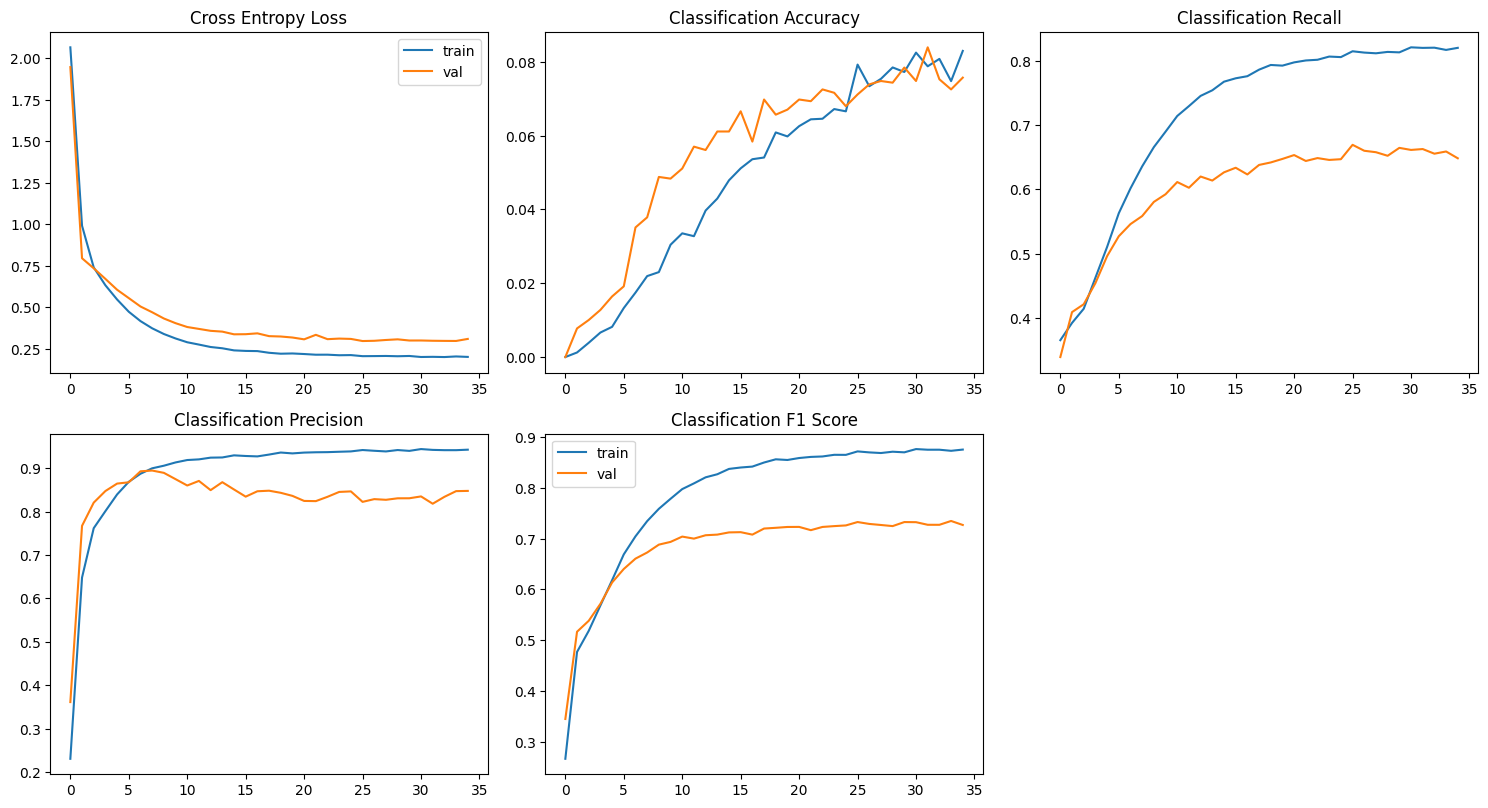

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
def plot_histogram(arr):
    max_histogram_missmatchs = 20
    arr_filtered = arr[:max_histogram_missmatchs]
    overMaxMissmachs = arr[max_histogram_missmatchs:]
    print("Filtered array:", arr_filtered)
    # Sum the values > max_histogram_missmatchs (if any exist)
    sum_over_16 = overMaxMissmachs.sum() if len(overMaxMissmachs) > 0 else 0

    # Create a new array for plotting (values ≤ 16 + one "16+" bin)
    new_arr = np.append(arr_filtered, sum_over_16)
    indices = np.arange(len(arr_filtered))
    indices = np.append(indices, str(max_histogram_missmatchs)+"+" )  # Add an index for the "16+" bin
    plt.figure(figsize=(8, 6))  # Wider graph (12 inches width, 6 height)
    # Plot the histogram (bar chart)
    plt.bar(indices, new_arr)

    # Add the numbers on top of each bar
    for i, value in enumerate(new_arr):
        if i == len(arr_filtered):
            plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom')
        plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Histogram of Array Values')
    plt.xticks(indices)  # Ensure all indices are shown

    # Display the plot
    plt.show()

100%|██████████| 267/267 [00:15<00:00, 17.33it/s]


All preds shape: torch.Size([2129, 64])
All preds shape: tensor([[ 1,  2,  3,  ...,  9,  8,  7],
        [ 1,  2,  3,  ...,  9,  8,  7],
        [ 1,  2,  3,  ...,  9,  8,  7],
        ...,
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12]])
Micro: Recall: 0.9126, Precision: 0.9126, F1: 0.9126
Missing pieces per board: [164  85  95 137 245 289 290 276 207 159  83  42  25  19   7   4   0   0
   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Filtered array: [164  85  95 137 245 289 290 276 207 159  83  42  25  19   7   4   0   0
   2   0]


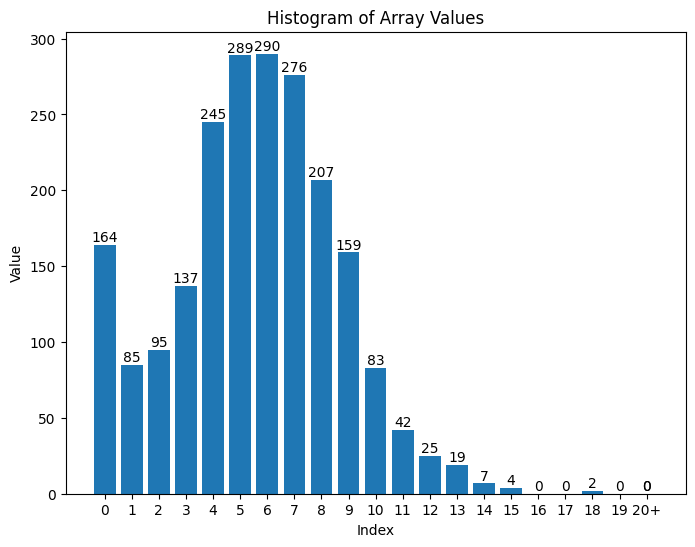

Test accuracy: 0.077, Test recall: 0.639, Test precision: 0.796, Test f1: 0.702


In [ ]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])
def test(dataloader):
    preds = []
    labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            #print("Pred shape:", pred.shape)
            predsTmp = pred.view(-1, 64, 13)
            preds.append(predsTmp.argmax(dim=-1).cpu())
            #print(predsTmp.argmax(dim=-1).cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        #print(labels.shape,preds.shape)
        all_preds = torch.cat(preds)
        all_labels = torch.cat(labels)
        print("All preds shape:", all_preds.shape)
        print("All preds shape:", all_preds)
        #print("All preds shape:",all_preds.shape,"All labels shape:",all_labels.shape)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        missing_list = claculateMissMatchs(all_preds, all_labels)
        print("Missing pieces per board:", missing_list)
        plot_histogram(missing_list)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

  0%|          | 0/267 [00:00<?, ?it/s]

Predictions:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


Ground Truth:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']
Micro: Recall: 0.9805, Precision: 0.9805, F1: 0.9805
Accuracy: 0.375, Recall: 0.971, Precision: 0.992, F1: 0.979


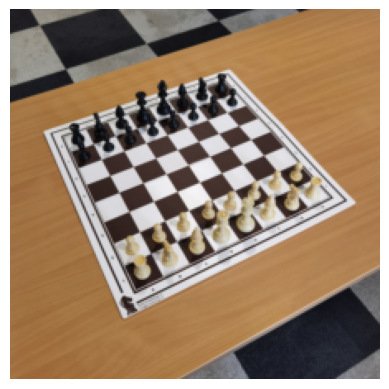

  0%|          | 1/267 [00:00<00:38,  6.94it/s]

Predictions:


['R', '-', 'B', 'K', 'Q', '-', 'N', 'R']
['P', 'P', 'P', '-', 'P', 'P', 'P', 'P']
['-', '-', 'N', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', '-', '-']
['p', 'p', 'p', '-', 'p', 'p', 'p', 'p']
['r', '-', 'b', 'k', 'q', '-', 'n', 'r']


Ground Truth:


['R', '-', 'B', 'K', 'Q', '-', 'N', 'R']
['P', 'P', 'P', '-', 'P', 'P', 'B', 'P']
['-', '-', 'N', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', '-', '-']
['p', 'p', 'p', '-', '-', 'p', 'p', 'p']
['r', '-', 'b', 'k', 'q', '-', 'n', 'r']
Micro: Recall: 0.9414, Precision: 0.9414, F1: 0.9414
Accuracy: 0.000, Recall: 0.916, Precision: 0.922, F1: 0.910


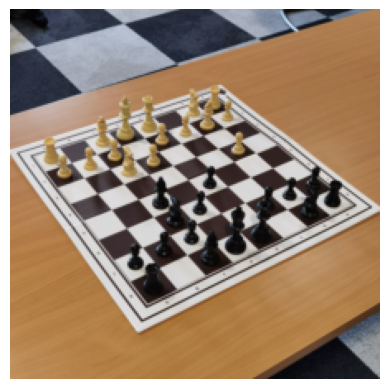

  1%|          | 2/267 [00:00<00:39,  6.78it/s]

Predictions:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', 'P', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'n', '-', '-']
['-', 'p', 'p', '-', '-', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']


Ground Truth:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', '-']
['-', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Micro: Recall: 0.9453, Precision: 0.9453, F1: 0.9453
Accuracy: 0.000, Recall: 0.903, Precision: 0.922, F1: 0.904


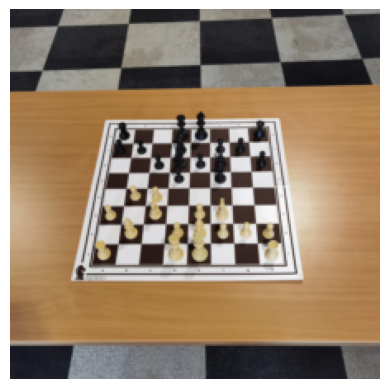

  1%|          | 3/267 [00:00<00:38,  6.83it/s]

Predictions:


['R', 'K', 'B', '-', 'Q', '-', '-', 'R']
['P', 'P', 'P', '-', '-', '-', 'P', '-']
['-', '-', 'P', '-', 'P', 'N', '-', 'P']
['-', '-', '-', 'P', '-', 'P', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', '-', 'n', '-', 'p', 'n', '-', 'p']
['-', 'p', 'p', '-', '-', '-', 'p', '-']
['r', '-', '-', '-', '-', '-', '-', 'r']


Ground Truth:


['-', 'K', 'R', '-', 'Q', '-', '-', 'R']
['P', 'P', 'P', '-', '-', '-', 'B', '-']
['-', '-', 'N', 'P', 'b', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'P', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', 'r', '-', '-', '-', '-', 'r']
Micro: Recall: 0.8926, Precision: 0.8926, F1: 0.8926
Accuracy: 0.000, Recall: 0.642, Precision: 0.736, F1: 0.659


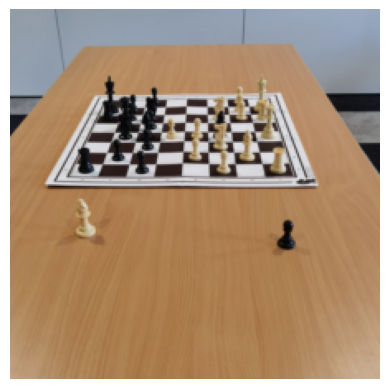

  1%|▏         | 4/267 [00:00<00:37,  7.03it/s]

Predictions:


['-', '-', '-', 'K', '-', '-', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', '-', '-']
['-', '-', 'N', 'P', '-', 'P', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'n', '-', 'p']
['-', 'b', 'p', '-', '-', '-', 'p', '-']
['r', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['K', 'P', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', 'n', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Micro: Recall: 0.8652, Precision: 0.8652, F1: 0.8652
Accuracy: 0.000, Recall: 0.460, Precision: 0.532, F1: 0.477


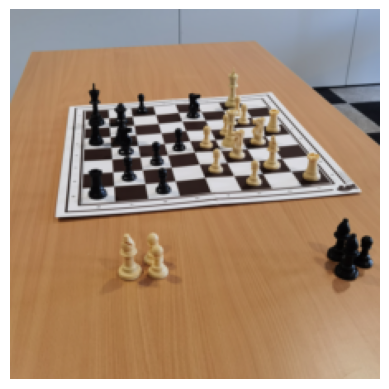

  2%|▏         | 5/267 [00:00<00:38,  6.81it/s]

Predictions:


['-', '-', '-', '-', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'N', '-', '-', '-']
['-', '-', '-', 'P', 'B', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', 'p']
['-', 'p', '-', '-', 'p', '-', 'p', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'q', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'N', '-', 'B', '-']
['-', 'K', '-', 'P', 'n', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', 'N']
['-', 'P', '-', '-', 'p', '-', 'p', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'n', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Micro: Recall: 0.9180, Precision: 0.9180, F1: 0.9180
Accuracy: 0.000, Recall: 0.546, Precision: 0.587, F1: 0.560


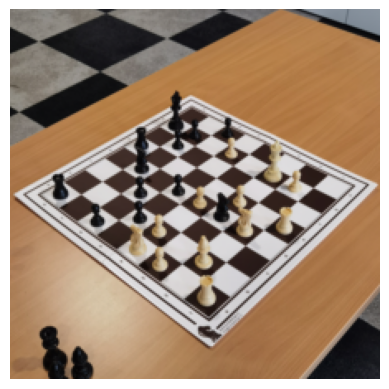

  2%|▏         | 5/267 [00:00<00:45,  5.72it/s]


In [ ]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    results = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.view(-1, 64, 13).argmax(dim=-1).cpu()
            print("Predictions:\n\n")
            print_readable_board(predsTmp[0])
            print("\n\nGround Truth:\n\n")
            print_readable_board(y.cpu()[0])
            #print(pred.cpu().shape, y.cpu().shape)
            #print(pred1)
            accuracy, recall, precision, f1 = calculate_metrics(predsTmp, y.cpu())
            print(f"Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
            #print(pred.cpu())
            #print(y.cpu())
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            results -= 1
            if results <0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?